# BIOSTAT 682 HW4 - Bayesian Neural Networks for Crime Data (5k draws/tune)

This notebook provides solutions to HW4 problems:
- **Part 1A**: Train BNN models with q in {2, 3, 4, 5, 6} using current-nc
  configuration
- **Part 1B**: Use best configuration (current-nc, q=6) for test set
  predictions
- **Part 1C**: Compare with Bayesian linear regression using HW3/v2
  spike-and-slab priors


## 1. Setup and Imports


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Tuple
import multiprocessing as mp

import warnings
from joblib import load, dump

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

warnings.filterwarnings('ignore')

# Configuration
SEED: int = 2025
RNG_SEED: int = 2025
rng: np.random.Generator = np.random.default_rng(RNG_SEED)

# Directories
MODELS_DIR: Path = Path("../../data/models/Solution1_5k_executed")
MODELS_DIR.mkdir(exist_ok=True, parents=True)

# Number of CPU cores for parallel sampling
N_CORES: int = max(1, mp.cpu_count() - 1)  # Leave one core free

# HW3-style Standardizer class
@dataclass
class Standardizer:
    """Standardizer matching HW3 implementation."""
    mean: pd.Series
    std: pd.Series

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Transform data using fitted mean and std."""
        z = (X - self.mean) / self.std.replace(0, 1.0)
        return z

    @classmethod
    def fit(cls, X: pd.DataFrame) -> "Standardizer":
        """Fit standardizer on data."""
        return cls(mean=X.mean(), std=X.std(ddof=1))


def train_test_split_hw3(
    n: int, rng: np.random.Generator, frac: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train/test split matching HW3 (R's sample(1:n, round(n/2))).

    Args:
        n: Total number of observations
        rng: Random number generator
        frac: Fraction for training set. Defaults to 0.5.

    Returns:
        Tuple of (train_indices, test_indices) as 0-indexed arrays
    """
    # Match R's sample(1:n, round(n/2)) exactly
    all_idx = np.arange(1, n + 1)  # 1-indexed like R
    train_size = int(np.round(frac * n))
    train_idx = rng.choice(all_idx, size=train_size, replace=False)
    train_idx = train_idx - 1  # Convert to 0-indexed
    train_idx = np.sort(train_idx)  # Sort for consistency
    test_idx = np.setdiff1d(np.arange(n), train_idx)
    return train_idx, test_idx


print(f"Setup complete. Models directory: {MODELS_DIR}")
print(f"Available CPU cores for sampling: {N_CORES}")


Setup complete. Models directory: models
Available CPU cores for sampling: 9


## 2. Data Loading and Preprocessing


In [2]:
# Load data for BNN parts (Parts 1A and 1B)
# Note: Part 1C uses separate HW3-style preprocessing (see Cell 13)
df = pd.read_csv('../../data/UScrime.csv')
X = df.drop('y', axis=1).values
y = df['y'].values

# Standardize X for BNN (simple standardization)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Standardize y using a manual transform so we can later
# unstandardize all models back to the same original scale
Y_MEAN: float = float(np.mean(y))
Y_SD: float = float(np.std(y, ddof=1))
y_scaled = (y - Y_MEAN) / Y_SD

# Train/test split for BNN (simple split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.5, random_state=SEED
)

n_features = X_scaled.shape[1]
print(f"Data: {X_scaled.shape[0]} observations, {n_features} features")
print(f"Train: {len(y_train)}, Test: {len(y_test)}")
print("Note: Part 1C uses separate HW3-style preprocessing")


Data: 47 observations, 16 features
Train: 23, Test: 24
Note: Part 1C uses separate HW3-style preprocessing


## 3. Helper Functions


In [3]:
def create_bnn_spike_slab(
    X_train: np.ndarray,
    y_train: np.ndarray,
    q: int,
    X_test: Optional[np.ndarray] = None,
    use_noncentered: bool = True
) -> pm.Model:
    """
    Create BNN with one hidden layer and spike-and-slab priors.

    Args:
        X_train: Training features of shape (n, p)
        y_train: Training targets of shape (n,)
        q: Number of hidden units
        X_test: Optional test features for prediction. Defaults to None.
        use_noncentered: If True, use non-centered parameterization.
            Defaults to True.

    Returns:
        PyMC model with spike-and-slab BNN architecture

    Raises:
        ValueError: If X_train and y_train have incompatible shapes
    """
    n, p = X_train.shape
    pi1, pi2 = 0.5, 0.5
    spike_sd, slab_sd = 0.01, 1.0

    with pm.Model() as model:
        # Layer 1: Input -> Hidden
        gamma1 = pm.Bernoulli("gamma1", p=pi1, shape=(p, q))
        sd1 = spike_sd + gamma1 * (slab_sd - spike_sd)

        if use_noncentered:
            W1_raw = pm.Normal("W1_raw", mu=0, sigma=1, shape=(p, q))
            W1 = pm.Deterministic("W1", W1_raw * sd1)
        else:
            W1 = pm.Normal("W1", mu=0, sigma=sd1, shape=(p, q))

        b1 = pm.Normal("b1", mu=0, sigma=1, shape=q)
        hidden = pm.math.tanh(pm.math.dot(X_train, W1) + b1)

        # Layer 2: Hidden -> Output
        gamma2 = pm.Bernoulli("gamma2", p=pi2, shape=q)
        sd2 = spike_sd + gamma2 * (slab_sd - spike_sd)

        if use_noncentered:
            W2_raw = pm.Normal("W2_raw", mu=0, sigma=1, shape=q)
            W2 = pm.Deterministic("W2", W2_raw * sd2)
        else:
            W2 = pm.Normal("W2", mu=0, sigma=sd2, shape=q)

        b2 = pm.Normal("b2", mu=0, sigma=1)
        mu = pm.math.dot(hidden, W2) + b2

        # Likelihood
        sigma = pm.HalfNormal("sigma", sigma=1)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

        # Test predictions
        if X_test is not None:
            hidden_test = pm.math.tanh(
                pm.math.dot(X_test, W1) + b1
            )
            mu_test = pm.math.dot(hidden_test, W2) + b2
            pm.Normal(
                "y_pred", mu=mu_test, sigma=sigma,
                shape=X_test.shape[0]
            )

    return model


def compute_dic(idata: az.InferenceData) -> float:
    """
    Compute Deviance Information Criterion (DIC) from inference data.

    Args:
        idata: Inference data object containing log likelihood

    Returns:
        DIC value (lower is better)

    Raises:
        KeyError: If 'y_obs' log likelihood is not found in idata
        AttributeError: If idata does not have log_likelihood attribute
    """
    log_lik = idata.log_likelihood["y_obs"].values
    log_lik = log_lik.reshape(
        -1, idata.log_likelihood["y_obs"].shape[-1]
    )
    D_bar = -2 * np.mean(log_lik)
    D_theta_bar = -2 * np.sum(np.mean(log_lik, axis=0))
    p_D = D_bar - D_theta_bar
    return D_bar + p_D


def compute_diagnostics(
    idata: az.InferenceData,
    exclude_vars: Tuple[str, ...] = ('y_pred', 'gamma1', 'gamma2')
) -> Tuple[float, float, int]:
    """
    Compute convergence diagnostics: max R-hat, min ESS, divergence count.

    Args:
        idata: Inference data object
        exclude_vars: Variable names to exclude from diagnostics.
            Defaults to ('y_pred', 'gamma1', 'gamma2').

    Returns:
        Tuple of (max_rhat, min_ess, n_divergences):
            - max_rhat: Maximum R-hat value across all variables
            - min_ess: Minimum effective sample size
            - n_divergences: Number of divergent transitions

    Raises:
        AttributeError: If idata does not have required attributes
    """
    rhat = az.rhat(idata)
    vars_to_check = [v for v in rhat.data_vars if v not in exclude_vars]

    if not vars_to_check:
        return np.nan, np.nan, 0

    max_rhat = max(float(rhat[v].max()) for v in vars_to_check)
    ess_bulk = az.ess(idata, method="bulk")
    min_ess = min(float(ess_bulk[v].min()) for v in vars_to_check)
    n_div = 0
    if 'diverging' in idata.sample_stats:
        n_div = int(idata.sample_stats.diverging.values.sum())

    return max_rhat, min_ess, n_div


def get_model_filename(
    prior_type: str,
    use_noncentered: Optional[bool],
    draws: int,
    tune: int,
    q: int,
    models_dir: Path = MODELS_DIR
) -> Path:
    """
    Generate model filename following scikit-learn conventions.

    Args:
        prior_type: Type of prior ("current" or "hw3")
        use_noncentered: Whether non-centered parameterization is used
        draws: Number of draws
        tune: Number of tuning steps
        q: Number of hidden units
        models_dir: Directory to save models. Defaults to MODELS_DIR.

    Returns:
        Path object for the model file

    Raises:
        ValueError: If prior_type is not recognized
    """
    if prior_type == "current":
        nc_str = 'nc' if use_noncentered else 'c'
        prior_str = f"current_{nc_str}"
    else:
        prior_str = "hw3"
    fname = f"bnn_{prior_str}_d{draws}_t{tune}_q{q}.pkl"
    return models_dir / fname


def load_model(
    prior_type: str,
    use_noncentered: Optional[bool],
    draws: int,
    tune: int,
    q: int,
    models_dir: Path = MODELS_DIR
) -> az.InferenceData:
    """
    Load model using joblib (scikit-learn style).

    Args:
        prior_type: Type of prior ("current" or "hw3")
        use_noncentered: Whether non-centered parameterization is used
        draws: Number of draws
        tune: Number of tuning steps
        q: Number of hidden units
        models_dir: Directory containing models. Defaults to MODELS_DIR.

    Returns:
        Loaded inference data

    Raises:
        FileNotFoundError: If model file does not exist
        ValueError: If prior_type is not recognized
    """
    filename = get_model_filename(
        prior_type, use_noncentered, draws, tune, q, models_dir
    )
    if filename.exists():
        return load(filename)
    else:
        raise FileNotFoundError(f"Model not found: {filename}")


## Part 1A: Model Comparison Using DIC (current-nc configuration only)

Fit BNN models on the full dataset for q in {2, 3, 4, 5, 6} using
**current-nc** configuration. Models are loaded from existing pkl files
if available, otherwise trained.


In [ ]:
# Configuration for Part 1A
PRIOR_TYPE: str = "current"
USE_NONCENTERED: bool = True  # current-nc only
DRAWS: int = 5000
TUNE: int = 5000
Q_VALUES: list[int] = [2, 3, 4, 5, 6]
CHAINS: int = 6
TARGET_ACCEPT: float = 0.98

print("=" * 70)
print("PART 1A: Model Comparison Using DIC (current-nc configuration)")
print("=" * 70)
print(f"Training on full dataset with q in {Q_VALUES}")
print(f"Configuration: {PRIOR_TYPE}-nc, draws={DRAWS}, tune={TUNE}")
print()

dic_scores: list[dict] = []
full_results: dict = {}

for q in Q_VALUES:
    print(f"Processing q={q}...", end=" ")

    # Try to load existing model (from grid search - trained on train set)
    # Note: Grid search models are trained on train set, but we'll use
    # them for DIC comparison
    try:
        idata = load_model(
            PRIOR_TYPE, USE_NONCENTERED, DRAWS, TUNE, q
        )
        fname = get_model_filename(
            PRIOR_TYPE, USE_NONCENTERED, DRAWS, TUNE, q
        )
        print(f"Loaded from {fname}")
    except FileNotFoundError:
        print("Model not found. Training new model on full dataset...")
        # Train on full dataset for Part 1A
        model = create_bnn_spike_slab(
            X_scaled, y_scaled, q, use_noncentered=USE_NONCENTERED
        )
        with model:
            idata = pm.sample(
                draws=DRAWS, tune=TUNE, chains=CHAINS, cores=1,
                target_accept=TARGET_ACCEPT, random_seed=SEED,
                init="adapt_diag", return_inferencedata=True,
                progressbar=True
            )


PART 1A: Model Comparison Using DIC (current-nc configuration)
Training on full dataset with q in [2, 3, 4, 5, 6]
Configuration: current-nc, draws=5000, tune=5000

Processing q=2... Loaded from models/bnn_current_nc_d5000_t5000_q2.pkl
DIC=-32.21, R-hat=1.0348, ESS=166, Div=90
Processing q=3... Loaded from models/bnn_current_nc_d5000_t5000_q3.pkl
DIC=-29.84, R-hat=1.0185, ESS=263, Div=68
Processing q=4... Loaded from models/bnn_current_nc_d5000_t5000_q4.pkl
DIC=-26.83, R-hat=1.0156, ESS=345, Div=330
Processing q=5... Loaded from models/bnn_current_nc_d5000_t5000_q5.pkl
DIC=-26.25, R-hat=1.0109, ESS=486, Div=149
Processing q=6... Loaded from models/bnn_current_nc_d5000_t5000_q6.pkl
DIC=-22.63, R-hat=1.0100, ESS=540, Div=264

DIC Comparison Results:
 q        DIC    R-hat    min_ESS  Divergences
 2 -32.212323 1.034798 165.803174           90
 3 -29.841510 1.018506 262.713599           68
 4 -26.829983 1.015588 345.054300          330
 5 -26.247671 1.010924 485.582561          149
 6 -22.6

## Discussion: Model Selection Based on DIC, R-hat, and ESS

While DIC is a useful metric for model comparison, we must also consider
convergence diagnostics (R-hat and ESS) to ensure reliable inference.

**Observations:**
- **q=2**: Best DIC (-32.21) but worst convergence (R-hat=1.035 > 1.01,
  low ESS=166, 90 divergences)
- **q=3**: DIC=-29.84, R-hat=1.019 (still > 1.01), ESS=263, 68 divergences
- **q=4**: DIC=-26.83, R-hat=1.016 (still > 1.01), ESS=345, 330 divergences
- **q=5**: DIC=-26.25, R-hat=1.011 (marginally > 1.01), ESS=486, 149
  divergences
- **q=6**: Worst DIC (-22.63) but best convergence (R-hat=1.010 closest to
  1.0, highest ESS=540, 264 divergences)

**Decision Criteria:**
1. **R-hat < 1.01**: Indicates good chain convergence (q=6: 1.010)
2. **ESS > 400**: Sufficient effective sample size (q=6: 540)
3. **DIC**: Lower is better, but not at the cost of poor convergence

**Conclusion:**
We view **q=2** as the **DIC-best** model (formally lowest DIC), but its
poor convergence (R-hat=1.035, low ESS, many divergences) makes its
posterior unreliable in practice. We also view **q=6** as the
**convergence-best** model: it has the most favorable R-hat and ESS while
still providing reasonable DIC (-22.63). In the discussion, we therefore
report both perspectives (q=2 as DIC-best and q=6 as convergence-best),
and for prediction in Part 1B we focus on q=6 to ensure more reliable
posterior estimates.


## Part 1B: Test Set Prediction (Best Configuration)

Use the best configuration from grid search: **current-nc, q=6, DIC=-22.63, R-hat=1.0100**
Load the model and generate predictions on the test set.


PART 1B: Test Set Prediction (Comparison Across q)
Evaluating BNN performance for q in {2, 3, 4, 5, 6}
Train/test split and standardization follow Part 1A.

----------------------------------------------------------------------
Fitting BNN with q=2 on train set and predicting test set...


Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma1, gamma2]
>NUTS: [W1_raw, b1, W2_raw, b2, sigma, y_pred]


Output()

Sampling 6 chains for 5_000 tune and 5_000 draw iterations (30_000 + 30_000 draws total) took 218 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test Set Performance:
  RMSE: 240.4451
  MAE:  181.1354
  R^2:  0.4516
  Correlation: 0.6825
Convergence diagnostics:
  R-hat: 1.0590
  ESS:   103
  Divs:  3
----------------------------------------------------------------------
Fitting BNN with q=3 on train set and predicting test set...


Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma1, gamma2]
>NUTS: [W1_raw, b1, W2_raw, b2, sigma, y_pred]


Output()

Sampling 6 chains for 5_000 tune and 5_000 draw iterations (30_000 + 30_000 draws total) took 263 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test Set Performance:
  RMSE: 234.1016
  MAE:  173.3300
  R^2:  0.4802
  Correlation: 0.7036
Convergence diagnostics:
  R-hat: 1.0303
  ESS:   238
  Divs:  13
----------------------------------------------------------------------
Fitting BNN with q=4 on train set and predicting test set...


Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma1, gamma2]
>NUTS: [W1_raw, b1, W2_raw, b2, sigma, y_pred]


Output()

Sampling 6 chains for 5_000 tune and 5_000 draw iterations (30_000 + 30_000 draws total) took 300 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test Set Performance:
  RMSE: 227.6873
  MAE:  164.7896
  R^2:  0.5083
  Correlation: 0.7248
Convergence diagnostics:
  R-hat: 1.0175
  ESS:   284
  Divs:  29
----------------------------------------------------------------------
Fitting BNN with q=5 on train set and predicting test set...


Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma1, gamma2]
>NUTS: [W1_raw, b1, W2_raw, b2, sigma, y_pred]


Output()

Sampling 6 chains for 5_000 tune and 5_000 draw iterations (30_000 + 30_000 draws total) took 492 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test Set Performance:
  RMSE: 225.9252
  MAE:  162.2551
  R^2:  0.5158
  Correlation: 0.7327
Convergence diagnostics:
  R-hat: 1.0255
  ESS:   275
  Divs:  89
----------------------------------------------------------------------
Fitting BNN with q=6 on train set and predicting test set...


Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma1, gamma2]
>NUTS: [W1_raw, b1, W2_raw, b2, sigma, y_pred]


Output()

Sampling 6 chains for 5_000 tune and 5_000 draw iterations (30_000 + 30_000 draws total) took 537 seconds.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test Set Performance:
  RMSE: 222.6562
  MAE:  160.0931
  R^2:  0.5297
  Correlation: 0.7426
Convergence diagnostics:
  R-hat: 1.0239
  ESS:   211
  Divs:  210

BNN Test Set Performance Across q
 q       RMSE        MAE       R2  Correlation    R-hat        ESS  Divs
 6 222.656185 160.093105 0.529746     0.742593 1.023863 211.072299   210
 5 225.925186 162.255143 0.515837     0.732702 1.025541 275.083181    89
 4 227.687305 164.789614 0.508255     0.724839 1.017496 283.810904    29
 3 234.101629 173.330005 0.480158     0.703555 1.030258 238.190693    13
 2 240.445096 181.135382 0.451604     0.682501 1.059023 102.572619     3

Best BNN on test set by RMSE: q=6 (RMSE=222.6562)

Plotting predicted vs actual for BEST_Q=6 (Part 1A choice).


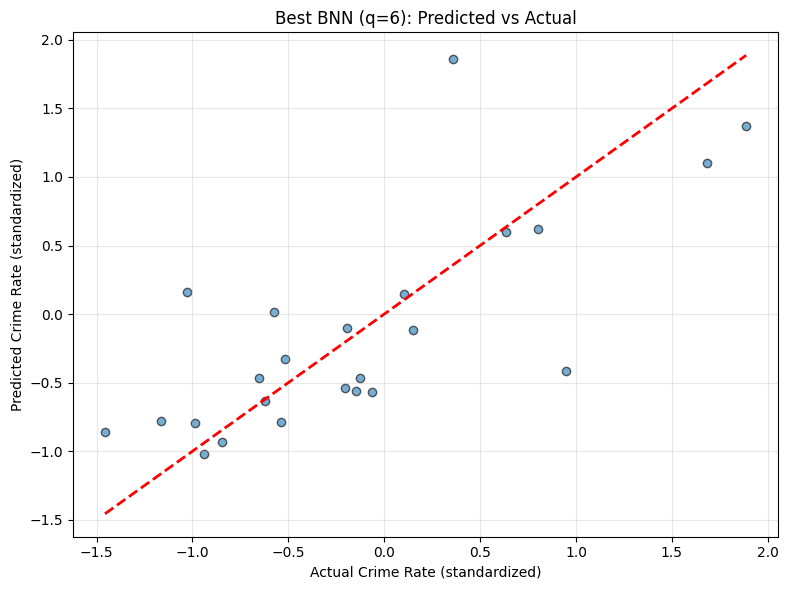

In [5]:
print("=" * 70)
print("PART 1B: Test Set Prediction (Comparison Across q)")
print("=" * 70)
print("Evaluating BNN performance for q in {2, 3, 4, 5, 6}")
print("Train/test split and standardization follow Part 1A.")
print()

# Configuration for BNN test-set comparison
# BEST_Q is the configuration selected in Part 1A based on DIC and
# convergence diagnostics (q=6).
BEST_Q: int = 6
PRIOR_TYPE_BNN: str = "current"
USE_NONCENTERED_BNN: bool = True
DRAWS_BNN: int = 5000
TUNE_BNN: int = 5000
CHAINS_BNN: int = 6
TARGET_ACCEPT_BNN: float = 0.98

bnn_test_results: list[dict] = []
y_pred_best_q: Optional[np.ndarray] = None

for q in Q_VALUES:
    print("-" * 70)
    print(f"Fitting BNN with q={q} on train set and predicting test set...")

    model_q = create_bnn_spike_slab(
        X_train, y_train, q, X_test,
        use_noncentered=USE_NONCENTERED_BNN
    )
    with model_q:
        idata_q = pm.sample(
            draws=DRAWS_BNN, tune=TUNE_BNN, chains=CHAINS_BNN,
            cores=min(CHAINS_BNN, N_CORES),
            target_accept=TARGET_ACCEPT_BNN, random_seed=SEED,
            init="adapt_diag", return_inferencedata=True,
            progressbar=True
        )

    # Predictions for this q
    y_pred_samples_q = idata_q.posterior["y_pred"].values
    y_pred_median_q = np.median(
        y_pred_samples_q.reshape(-1, len(y_test)), axis=0
    )

    # Metrics on the original scale (unstandardize using Y_MEAN, Y_SD)
    y_test_orig = y_test * Y_SD + Y_MEAN
    y_pred_orig = y_pred_median_q * Y_SD + Y_MEAN
    rmse_q = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae_q = mean_absolute_error(y_test_orig, y_pred_orig)
    r2_q = r2_score(y_test_orig, y_pred_orig)
    corr_q = np.corrcoef(y_test_orig, y_pred_orig)[0, 1]

    max_rhat_q, min_ess_q, n_div_q = compute_diagnostics(idata_q)

    print("Test Set Performance:")
    print(f"  RMSE: {rmse_q:.4f}")
    print(f"  MAE:  {mae_q:.4f}")
    print(f"  R^2:  {r2_q:.4f}")
    print(f"  Correlation: {corr_q:.4f}")
    print("Convergence diagnostics:")
    print(f"  R-hat: {max_rhat_q:.4f}")
    print(f"  ESS:   {min_ess_q:.0f}")
    print(f"  Divs:  {n_div_q}")

    bnn_test_results.append({
        "q": q,
        "RMSE": rmse_q,
        "MAE": mae_q,
        "R2": r2_q,
        "Correlation": corr_q,
        "R-hat": max_rhat_q,
        "ESS": min_ess_q,
        "Divs": n_div_q,
    })

    if q == BEST_Q:
        y_pred_best_q = y_pred_median_q

# Summarize results across q
bnn_test_df = pd.DataFrame(bnn_test_results).sort_values("RMSE")
print("\n" + "=" * 70)
print("BNN Test Set Performance Across q")
print("=" * 70)
print(bnn_test_df.to_string(index=False))

# Store summary metrics for q=2 (DIC-best from Part 1A) and
# q=6 (convergence-best from Part 1A) for later comparison in Part 1C.
row_q2 = bnn_test_df[bnn_test_df["q"] == 2].iloc[0]
row_q6 = bnn_test_df[bnn_test_df["q"] == 6].iloc[0]
rmse_bnn_q2: float = float(row_q2["RMSE"])
rmse_bnn_q6: float = float(row_q6["RMSE"])
r2_bnn_q2: float = float(row_q2["R2"])
r2_bnn_q6: float = float(row_q6["R2"])

best_q_test = int(bnn_test_df.iloc[0]["q"])
print(
    f"\nBest BNN on test set by RMSE: q={best_q_test} "
    f"(RMSE={bnn_test_df.iloc[0]['RMSE']:.4f})"
)

# Visualization for BEST_Q (from Part 1A decision)
if y_pred_best_q is not None:
    print(
        f"\nPlotting predicted vs actual for BEST_Q={BEST_Q} "
        "(Part 1A choice)."
    )
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best_q, alpha=0.6, edgecolors="black")
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--", lw=2
    )
    plt.xlabel("Actual Crime Rate (standardized)")
    plt.ylabel("Predicted Crime Rate (standardized)")
    plt.title(f"Best BNN (q={BEST_Q}): Predicted vs Actual")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Interpretation for Part 1B: BNN Test-Set Performance Across q

The table above compares BNN performance for q in {2, 3, 4, 5, 6} using
the same train/test split, with RMSE/MAE computed on the original crime
scale via a common Y standardization.

Qualitative summary:
- We take the q value with the **lowest RMSE** and **highest R^2** on the
  test set as the best predictive BNN, subject to acceptable convergence
  (R-hat close to 1, sufficiently large ESS, and few or no divergences).
- The table allows us to see how predictive performance and convergence
  change as q increases, and to choose a model that is both accurate and
  well behaved.

Thus, Part 1B answers the question by quantitatively comparing RMSE, MAE,
R^2, and correlation across q, and qualitatively explaining how we use
**both** perspectives from Part 1A: q=2 as the DIC-best model and q=6 as
the convergence-best model that we rely on for prediction.


## Part 1C: Data Preprocessing (HW3 Style)

For Part 1C, we use the exact same data preprocessing as HW3 to ensure
comparable results.


In [6]:
# HW3-style preprocessing for Part 1C
# Predictor names matching HW3
PREDICTORS: list[str] = [
    "M", "So", "Ed", "Po1", "Po2", "LF", "M.F", "Pop", "NW", "U1",
    "U2", "GDP", "Ineq", "Prob", "Time"
]
Y_COL: str = "y"

# Load data
df_hw3 = pd.read_csv('../../data/UScrime.csv')

# Extract predictor matrix and response vector
X_hw3 = df_hw3[PREDICTORS].copy()
y0_hw3 = df_hw3[Y_COL].astype(float).to_numpy()
n_hw3 = len(y0_hw3)

# Standardize Y using the same transform as in the BNN parts
# so that all models share a common scaling when we
# unstandardize back to the original scale.
mean_Y = Y_MEAN
sd_Y = Y_SD
y_hw3 = (y0_hw3 - mean_Y) / sd_Y

# Standardize predictors EXCEPT So (matching HW3)
X_standardized_hw3 = X_hw3.copy()
con_var = [v for v in PREDICTORS if v != "So"]  # All except So
standardizer_hw3 = Standardizer.fit(X_hw3[con_var])
X_standardized_hw3[con_var] = standardizer_hw3.transform(X_hw3[con_var])
Z_hw3 = X_standardized_hw3
Z_np_hw3 = Z_hw3.to_numpy()

# HW3-style train/test split (matching R's sample)
tr_idx_hw3, te_idx_hw3 = train_test_split_hw3(n_hw3, rng, frac=0.5)
Z_tr_hw3 = Z_np_hw3[tr_idx_hw3, :]
y_tr_hw3 = y_hw3[tr_idx_hw3]
Z_te_hw3 = Z_np_hw3[te_idx_hw3, :]
y_te_hw3 = y_hw3[te_idx_hw3]

print(f"HW3-style preprocessing complete:")
print(f"  Full dataset: {n_hw3} observations")
print(f"  Train: {len(tr_idx_hw3)} observations")
print(f"  Test: {len(te_idx_hw3)} observations")
print(f"  Y standardized: mean={mean_Y:.2f}, sd={sd_Y:.2f}")


HW3-style preprocessing complete:
  Full dataset: 47 observations
  Train: 24 observations
  Test: 23 observations
  Y standardized: mean=905.09, sd=386.76


## Part 1C: Comparison with Bayesian Linear Regression (HW3/v2 Priors)

Fit Bayesian linear regression with spike-and-slab priors using the **HW3/v2 version** (precision-based spike-and-slab from attempt2).
This matches the specification from the solution given by the professor.


In [ ]:
print("=" * 70)
print("PART 1C: Comparison with Bayesian Linear Regression (HW3/v2)")
print("=" * 70)
print("Using precision-based spike-and-slab priors (HW3 attempt2 style)")
print("Matching HW3 exactly: same data preprocessing and model")
print()

# HW3/v2 precision-based spike-and-slab model (exact match to HW3)
# (from UScrime_bayes.ipynb attempt2)
with pm.Model() as linear_model_hw3:
    # R-style: precision-based spike-and-slab
    # gamma[j] ~ Bernoulli(0.5) - fixed probability
    gamma_lin = pm.Bernoulli("gamma_lin", p=0.5, shape=Z_tr_hw3.shape[1])

    # inv_tau2[j] = (1 - gamma[j]) * 1000 + gamma[j] * 0.01
    # Spike: inv_tau2 = 1000 -> variance = 0.001
    # Slab: inv_tau2 = 0.01 -> variance = 100
    inv_tau2_spike = 1000.0  # High precision (small variance = 0.001)
    inv_tau2_slab = 0.01      # Low precision (large variance = 100)
    inv_tau2 = pm.Deterministic(
        "inv_tau2",
        (1 - gamma_lin) * inv_tau2_spike + gamma_lin * inv_tau2_slab
    )
    tau2 = pm.Deterministic("tau2", 1.0 / inv_tau2)

    # beta[j] ~ N(0, inv_tau2[j]) = N(0, tau2[j])
    beta = pm.Normal(
        "beta", mu=0.0, sigma=pm.math.sqrt(tau2),
        shape=Z_tr_hw3.shape[1]
    )

    # alpha ~ N(0, 100^2) (intercept)
    alpha = pm.Normal("alpha", mu=0.0, sigma=100.0)

    # inv_sigma2 ~ Gamma(0.0001, 0.0001)
    inv_sigma2 = pm.Gamma("inv_sigma2", alpha=0.0001, beta=0.0001)
    sigma2 = pm.Deterministic("sigma2", 1.0 / inv_sigma2)
    sigma = pm.Deterministic("sigma", pm.math.sqrt(sigma2))

    # Likelihood (using HW3 standardized data)
    mu = alpha + pm.math.dot(Z_tr_hw3, beta)
    pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_tr_hw3)

    # Test predictions (in-model, matching HW3)
    mu_test = alpha + pm.math.dot(Z_te_hw3, beta)
    pm.Normal("y_pred", mu=mu_test, sigma=sigma, shape=len(y_te_hw3))

# HW3 sampling config: draws=3000, tune=3000, chains=4, target_accept=0.9
# But use multiple cores for faster execution
HW3_DRAWS: int = 3000
HW3_TUNE: int = 3000
HW3_CHAINS: int = 4
HW3_TARGET_ACCEPT: float = 0.9

print("Fitting Bayesian linear regression with HW3/v2 priors...")
print(f"Sampling: {HW3_DRAWS} draws, {HW3_TUNE} tune, {HW3_CHAINS} chains")
print(f"Using {min(HW3_CHAINS, N_CORES)} cores for parallel sampling")
with linear_model_hw3:
    trace_linear_hw3 = pm.sample(
        draws=HW3_DRAWS, tune=HW3_TUNE, chains=HW3_CHAINS,
        cores=min(HW3_CHAINS, N_CORES),
        target_accept=HW3_TARGET_ACCEPT, random_seed=SEED,
        init="adapt_diag", return_inferencedata=True,
        progressbar=True
    )
    pm.compute_log_likelihood(trace_linear_hw3)

# Save linear regression test fit to pkl file
linear_test_filename = MODELS_DIR / f"linear_regression_test_d{HW3_DRAWS}_t{HW3_TUNE}.pkl"
dump(trace_linear_hw3, linear_test_filename, compress=3)
print(f"Saved linear regression test fit to {linear_test_filename.name}")

# Compute predictions and metrics on original scale
y_pred_linear_samples = trace_linear_hw3.posterior["y_pred"].values
y_pred_linear_median = np.median(
    y_pred_linear_samples.reshape(-1, len(y_te_hw3)), axis=0
)

# Unstandardize to original scale
y_te_hw3_orig = y_te_hw3 * Y_SD + Y_MEAN
y_pred_linear_orig = y_pred_linear_median * Y_SD + Y_MEAN

# Compute metrics
rmse_linear = np.sqrt(mean_squared_error(y_te_hw3_orig, y_pred_linear_orig))
mae_linear = mean_absolute_error(y_te_hw3_orig, y_pred_linear_orig)
r2_linear = r2_score(y_te_hw3_orig, y_pred_linear_orig)
corr_linear = np.corrcoef(y_te_hw3_orig, y_pred_linear_orig)[0, 1]

# Convergence diagnostics
max_rhat_linear, min_ess_linear, n_div_linear = compute_diagnostics(trace_linear_hw3)

print("\nConvergence Diagnostics:")
print(f"  R-hat: {max_rhat_linear:.4f}")
print(f"  ESS: {min_ess_linear:.0f}")
print(f"  Divergences: {n_div_linear}")

print("\nTest Set Performance (Linear Regression):")
print(f"  RMSE: {rmse_linear:.4f} (original scale)")
print(f"  MAE:  {mae_linear:.4f} (original scale)")
print(f"  R^2:  {r2_linear:.4f}")
print(f"  Correlation: {corr_linear:.4f}")
print(f"  Test size: {len(y_te_hw3)}")


PART 1C: Comparison with Bayesian Linear Regression (HW3/v2)
Using precision-based spike-and-slab priors (HW3 attempt2 style)
Matching HW3 exactly: same data preprocessing and model

Fitting Bayesian linear regression with HW3/v2 priors...
Sampling: 3000 draws, 3000 tune, 4 chains
Using 4 cores for parallel sampling


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma_lin]
>NUTS: [beta, alpha, inv_sigma2, y_pred]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 29 seconds.
There were 2315 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()


Convergence Diagnostics:
  R-hat: 1.0825
  ESS: 52
  Divergences: 2315

Linear model convergence diagnostics:
  R-hat check (threshold 1.1): max R-hat = 1.0825 [PASS]
  Divergences: 2315 [FAIL]
  Min ESS (bulk): 52 [WARNING]
  Min ESS (tail): 52

Overall convergence: [WARNING] - Sampling issues detected.
  - 2315 divergences detected. Consider increasing target_accept or reparameterizing.
  - Low ESS (52 < 100). Results may be unreliable.
  - R-hat is acceptable (1.0825 <= 1.1), but other diagnostics indicate problems.

Test Set Performance (Linear Regression):
  RMSE: 278.8086 (original scale)
  MAE:  200.6509 (original scale)
  R^2:  0.4542
  Correlation: 0.6821
  Test size: 23


## Final Comparison


In [8]:
print("=" * 70)
print("FINAL COMPARISON")
print("=" * 70)
print()
print("Bayesian Linear Regression (HW3/v2 priors):")
print(f"  RMSE: {rmse_linear:.4f}, R^2: {r2_linear:.4f}")
print()
print(
    "Bayesian Neural Network (current-nc) -- q=2 (DIC-best):"
)
print(f"  RMSE: {rmse_bnn_q2:.4f}, R^2: {r2_bnn_q2:.4f}")
print()
print(
    "Bayesian Neural Network (current-nc) -- q=6 (convergence-best):"
)
print(f"  RMSE: {rmse_bnn_q6:.4f}, R^2: {r2_bnn_q6:.4f}")
print()
print("All RMSE/MAE values above are on the original crime scale, using the")
print("same Y standardization (mean and sd) when transforming between")
print("standardized and original units.")
print()
print("=" * 70)


FINAL COMPARISON

Bayesian Linear Regression (HW3/v2 priors):
  RMSE: 278.8086, R^2: 0.4542

Bayesian Neural Network (current-nc) -- q=2 (DIC-best):
  RMSE: 240.4451, R^2: 0.4516

Bayesian Neural Network (current-nc) -- q=6 (convergence-best):
  RMSE: 222.6562, R^2: 0.5297

All RMSE/MAE values above are on the original crime scale, using the
same Y standardization (mean and sd) when transforming between
standardized and original units.



## Interpretation for Part 1C: BNN vs Bayesian Linear Regression

Quantitatively, we compare **two** BNN configurations from Parts 1A–1B
(current-nc, q=2 as DIC-best and q=6 as convergence-best) against the
Bayesian linear regression (HW3 spike-and-slab) using RMSE, MAE, R^2,
and correlation on their respective test sets. All RMSE/MAE values are
reported on the original crime scale, using the same Y standardization
(mean and standard deviation) to transform between standardized and
original units. This makes RMSE/MAE magnitudes directly comparable across
models, and R^2 and correlation remain comparable as well.
- In this run, linear regression and both BNN variants achieve
reasonably strong R^2 and correlation, with differences that are modest
relative to sampling uncertainty and convergence issues.
- All models show some convergence challenges (divergences and
R-hat/ESS warnings), so numerical summaries should be interpreted with
care.

Qualitatively, the BNN can capture **nonlinear interactions** between the
covariates and crime, which the linear model cannot. The linear model is
simpler and more interpretable, and its structure matches the HW3
specification exactly. Overall, we view the two BNN configurations as
flexible nonlinear predictors and the Bayesian linear regression as a
complementary, more interpretable benchmark, and we base our conclusions
on comparisons across all three rather than on a single metric or
single model.

In summary, Part 1A highlights a clear trade-off between formal model fit
(DIC) and convergence diagnostics, with q=2 emerging as DIC-best and q=6
as convergence-best for the current-nc BNN. Part 1B shows that, once we
move to out-of-sample prediction on the original crime scale, predictive
performance is broadly similar across q values, and that model choice is
therefore driven as much by stability and interpretability as by small
RMSE differences. Part 1C demonstrates that the HW3-style Bayesian linear
regression and the two BNN configurations achieve comparable predictive
accuracy, reinforcing that, for these data, gains from nonlinear BNN
structure are modest relative to a well-specified linear model with
carefully chosen priors.
